**Analysis owner**: Felipe Matheus <br>
**Date**: 12/10/2021 <br>
**Related Links**:

The objective of this notebook is to asses data from Jeff and create a DataFrame modeling the problem.

# Setup

Libs

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#import warnings

%load_ext autoreload
%autoreload 2

Modules

In [120]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.DataLoader import DataLoader
from src.processing.Processing import Processing
from src.visualization.Plots import Plots
from src.feature_engineering.FeatureEngineering import FeatureEngineering
from src.utils import read_files

Variables

In [3]:
pd.options.display.max_rows = 6
# warnings.filterwarnings("ignore")
with open('../config/variables.json') as json_file:
    var = json.load(json_file)
RAW_DATA = var.get('RAW_DATA')
TRAIN_FOLDER = var.get('TRAIN_FOLDER')
TEST_FOLDER = var.get('TEST_FOLDER')

Objects

In [121]:
load = DataLoader(RAW_DATA)
processing = Processing()
plots = Plots()
feng = FeatureEngineering()

# Loading files

In [21]:
fits = load.load_fits(read_files(RAW_DATA))
energies = processing.get_energy_dict(fits)

In [22]:
energies

{'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
         68.28175692, 165.50336178]),
 'ba': array([79.2461234 , 32.05256775, 82.40269725, ..., 23.9200605 ,
        34.94371734, 10.8930531 ]),
 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
        22.68337052, 29.00606452]),
 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
        168.7988886 , 123.45042534]),
 'co': array([ 16.5188232 ,  25.5491515 ,  56.8609797 , ..., 119.90803846,
        118.33637915, 121.63595295]),
 'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
        120.36540315,  19.78994792]),
 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
         8.4234955 , 36.1971228 ])}

Assessing if they have the same lenght

In [25]:
for key in energies.keys():
    print(len(energies[key]))

658548
15852843
14217618
135563
3394654
12487896
9220770


The lowest possible sum will be: <br>
3394654 <br>
0135563 + <br>
<br>
3530217

# Plotting distribution

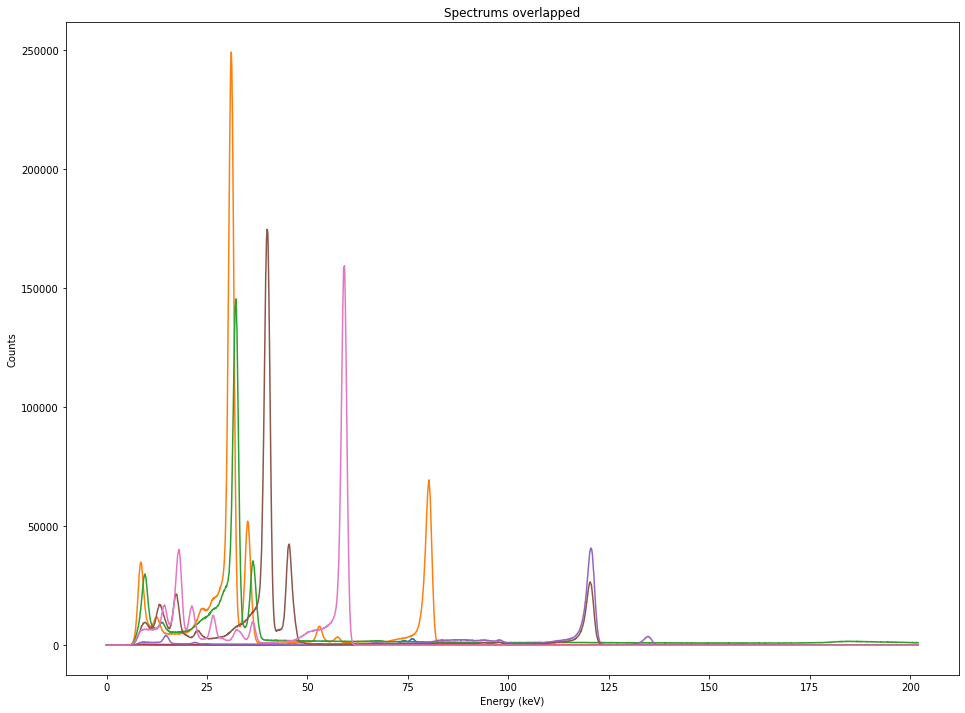

In [86]:
plots.plot_spectrums_overlapping(energies, "Spectrums overlapped")

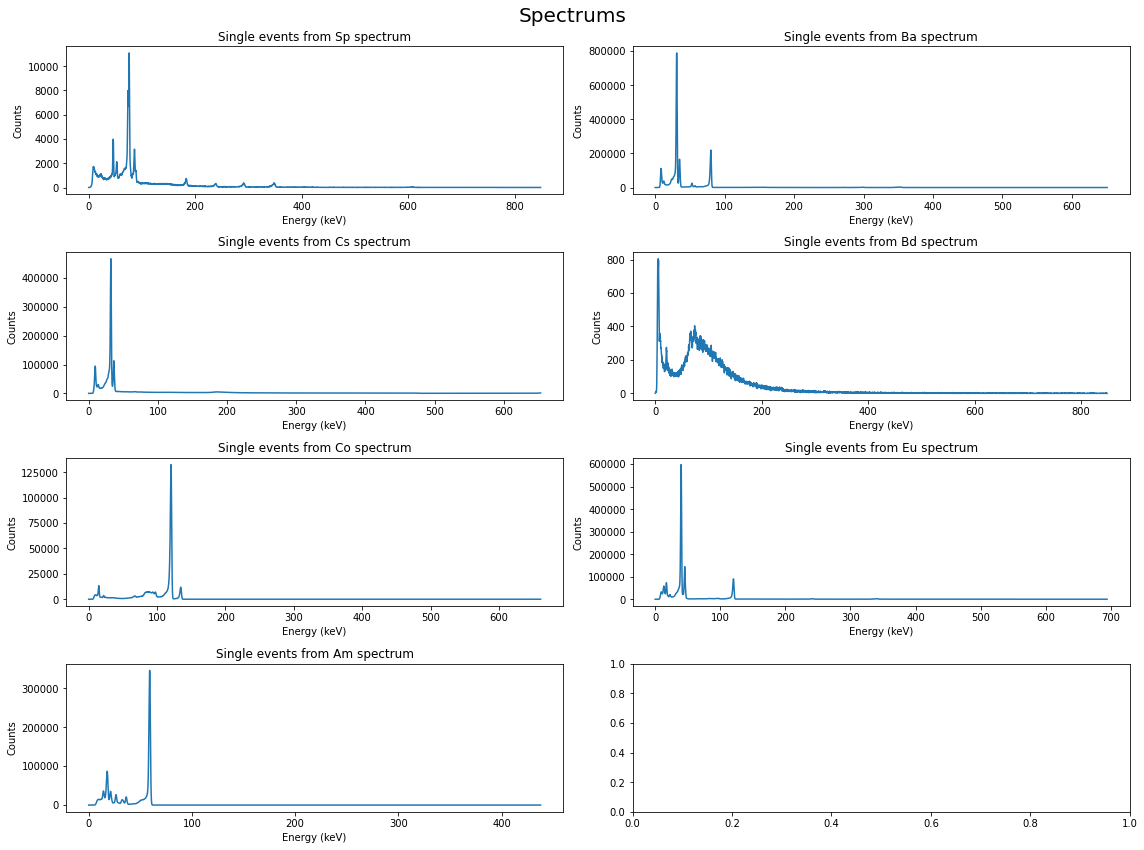

In [79]:
plots.plot_spectrums(energies, "Spectrums")

# Mixing and creating DataFrame

Each mixed sample will have size of 3530217 / reduction factor, because it is the lowest possible lenght (which would be Bd source with Co source).

We need to add a reduction factor because if it would be 1, the model would always guess right the combination Bd with Co.

The bigger the reduction factor, harder will be for the model. So we expect our accuracy will be inversely proportional to this reduction factor.

#### Important Observation: What happen if 2 photons from 2 different sources hit the same pixel at the same time? Does it count as a sum?

In [153]:
REDUCTION_FACTOR = 4
MINIMUM_COMBINATION_LENGHT = len(energies["bd"]) + len(energies["co"])
OUTPUT_SIZE = MINIMUM_COMBINATION_LENGHT//REDUCTION_FACTOR
HALF_OUTPUT_SIZE = OUTPUT_SIZE//2

In [134]:
%%time
s = feng.mix_numpy_arrays(
    array1=energies['sp'],
    array2=energies['ba'],
    output_size=OUTPUT_SIZE
)

CPU times: user 1.19 s, sys: 185 ms, total: 1.37 s
Wall time: 1.39 s


In [135]:
%%time
s = feng.mix_lists(
    list1=energies['sp'].tolist(),
    list2=energies['ba'].tolist(),
    output_size=OUTPUT_SIZE
)

CPU times: user 13.6 s, sys: 256 ms, total: 13.9 s
Wall time: 14.9 s


In [137]:
%%time
random.shuffle(energies['sp'].tolist())

CPU times: user 431 ms, sys: 0 ns, total: 431 ms
Wall time: 432 ms


In [138]:
%%time
np.random.shuffle(energies['sp'])

CPU times: user 31.3 ms, sys: 360 µs, total: 31.7 ms
Wall time: 40.4 ms


In [140]:
%%time
s = feng.mix_numpy_arrays(
    array1=energies['sp'],
    array2=energies['ba'],
    output_size=OUTPUT_SIZE
)

CPU times: user 676 ms, sys: 31.8 ms, total: 708 ms
Wall time: 706 ms


In [145]:
arr[:5]

array([1, 9, 3, 5, 6])

In [147]:
OUTPUT_SIZE//4

220638

In [154]:
%%time
s = feng.mix_numpy_arrays(
    array1=energies['sp'],
    array2=energies['ba'],
    amount_first_array=HALF_OUTPUT_SIZE,
    amount_second_array=HALF_OUTPUT_SIZE
)

CPU times: user 664 ms, sys: 0 ns, total: 664 ms
Wall time: 674 ms


In [161]:
np.concatenate(
    [np.random.choice(arr2, 4),
    np.random.choice(arr2, 4)]
)

array([14, 13,  2,  2,  2,  4,  5, 16])

In [162]:
%%time
s = feng.mix_numpy_arrays(
    array1=energies['sp'],
    array2=energies['ba'],
    amount_first_array=HALF_OUTPUT_SIZE,
    amount_second_array=HALF_OUTPUT_SIZE
)

CPU times: user 17.1 ms, sys: 114 µs, total: 17.2 ms
Wall time: 17.1 ms


In [158]:
HALF_OUTPUT_SIZE

441277

In [136]:
import random

In [90]:
type(energies['sp'])

numpy.ndarray

In [91]:
energies

{'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
         68.28175692, 165.50336178]),
 'ba': array([79.2461234 , 32.05256775, 82.40269725, ..., 23.9200605 ,
        34.94371734, 10.8930531 ]),
 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
        22.68337052, 29.00606452]),
 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
        168.7988886 , 123.45042534]),
 'co': array([ 16.5188232 ,  25.5491515 ,  56.8609797 , ..., 119.90803846,
        118.33637915, 121.63595295]),
 'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
        120.36540315,  19.78994792]),
 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
         8.4234955 , 36.1971228 ])}

In [102]:
arr = np.arange(10)
arr2 = np.arange(20)

In [105]:
arr2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [113]:
s = arr.tolist().append(arr2.tolist())

In [119]:
arr.tolist()[:4]

[1, 9, 3, 5]

In [110]:
np.random.shuffle(arr)

In [87]:
df_sr

,event_num,mult,mult_i,time,pixel,x,y,energy,event_type,label
0,0,1,0,0.000000,241,1,15,72.422764,1,SR
1,1,1,0,0.214265,78,14,4,76.794589,1,SR
2,2,1,0,0.257149,215,7,13,152.931080,1,SR
...,...,...,...,...,...,...,...,...,...,...
1304410,-19516,1,0,61444.001697,173,13,10,59.786638,1,SR
1304411,-19515,1,0,61444.097826,193,1,12,68.281757,1,SR
1304412,-19514,1,0,61444.112442,34,2,2,165.503362,1,SR


In [ ]:
# todos os arquivos são os dados reais, mas são pas prises pendant
# la meme condition
#Am -> Amerique
# TP8 -> configuration electronique de 1 a 15
# g0 -> outro parâmetro
# BdF -> bruit de fundo. 
# A gente seleciona
#reveil -> alarm


Text(0.5, 1.0, 'Spectre single events')

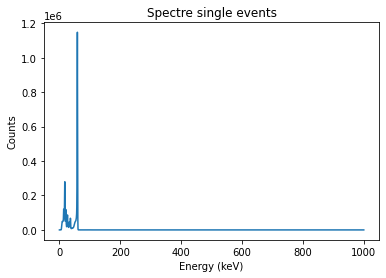

In [4]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,1000),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


Text(0.5, 1.0, 'Spectre single events')

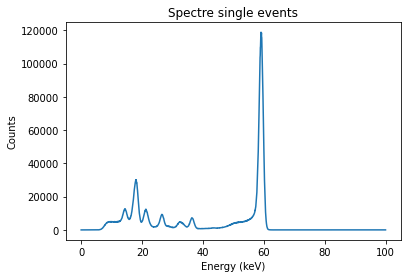

In [6]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,100),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


In [ ]:
on reste avec la multiplicite 1, e melanja com o americium e barium
mistrurar os bagulhos e dai dizer quais que tem
pega esse espectro bonitao, melanja com o dos radioativos 

faz uma coisa parecida com o hotel unico, mistura os espectros com uma porcentagem aleatoria
identifica quais espectros eu to misturando, labeliza eles e depois bota pra treinar. Socalhe AutoMLl

In [ ]:
        # for file in files:
        #     hdulist = fits.open(self.folder+file)
        #     ans[f"{file.lower()}_header"]= hdulist[1].header
        #     ans[f"{file.lower()}_tabdata"]= hdulist[1].data
        #     hdulist.close()

        # return ans
